SAC的简化版实现,alpha使用常量代替.只使用一个value模型,而不是两个.

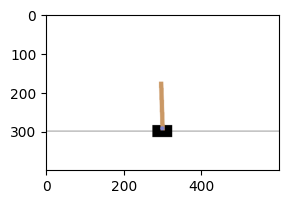

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch

model_action = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

model_action(torch.randn(2, 4))

tensor([[0.4698, 0.5302],
        [0.4947, 0.5053]], grad_fn=<SoftmaxBackward0>)

In [3]:
model_value = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model_value_next = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model_value_next.load_state_dict(model_value.state_dict())

model_value(torch.randn(2, 4))

tensor([[0.0394, 0.0585],
        [0.0586, 0.0380]], grad_fn=<AddmmBackward0>)

In [4]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        prob = model_action(torch.FloatTensor(state).reshape(1, 4))[0].tolist()
        action = random.choices(range(2), weights=prob, k=1)[0]

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

/root/miniconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


80.0

In [5]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()

len(pool), pool[0]

/tmp/ipykernel_6002/3891364554.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(223,
 (array([ 0.01138922, -0.00029995,  0.00196026, -0.0162883 ], dtype=float32),
  1,
  1.0,
  array([ 0.01138322,  0.19479384,  0.0016345 , -0.3083521 ], dtype=float32),
  False))

In [6]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=2e-4)
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=2e-3)


def soft_update(_from, _to):
    for _from, _to in zip(_from.parameters(), _to.parameters()):
        value = _to.data * 0.995 + _from.data * 0.005
        _to.data.copy_(value)


def get_prob_entropy(state):
    prob = model_action(torch.FloatTensor(state).reshape(-1, 4))
    entropy = prob * (prob + 1e-8).log()
    entropy = -entropy.sum(dim=1, keepdim=True)

    return prob, entropy


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)

In [7]:
def train_value(state, action, reward, next_state, over):
    requires_grad(model_value, True)
    requires_grad(model_action, False)

    #计算target
    with torch.no_grad():
        #计算动作的熵
        prob, entropy = get_prob_entropy(next_state)
        target = model_value_next(next_state)

    #加权熵,熵越大越好
    target = (prob * target).sum(dim=1, keepdim=True)
    target = target + 1e-3 * entropy
    target = target * 0.98 * (1 - over) + reward

    #计算value
    value = model_value(state).gather(dim=1, index=action)
    loss = torch.nn.functional.mse_loss(value, target)
    loss.backward()
    optimizer_value.step()
    optimizer_value.zero_grad()

    return loss.item()


train_value(state, action, reward, next_state, over)

1.003380298614502

In [8]:
def train_action(state):
    requires_grad(model_value, False)
    requires_grad(model_action, True)

    #计算熵
    prob, entropy = get_prob_entropy(state)

    #计算value
    value = model_value(state)

    #求期望求和
    value = (prob * value).sum(dim=1, keepdim=True)

    #加权熵
    loss = -(value + 1e-3 * entropy).mean()

    loss.backward()
    optimizer_action.step()
    optimizer_action.zero_grad()

    return loss.item()


train_action(state)

-0.06116258352994919

In [9]:
def train():
    model_action.train()
    model_value.train()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        pool.update()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = pool.sample()

            #训练
            train_value(state, action, reward, next_state, over)
            train_action(state)
            soft_update(model_value, model_value_next)

        if epoch % 10 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), test_result)


train()

0 428 11.1
10 2577 182.25
20 5248 139.15
30 7842 134.15
40 10673 133.9
50 13204 125.8
60 15715 117.8
70 18036 107.3
80 20000 115.0
90 20000 172.1
100 20000 190.85
110 20000 194.55
120 20000 180.1
130 20000 189.3
140 20000 199.75
150 20000 195.3
160 20000 175.4
170 20000 190.9
180 20000 191.5
190 20000 145.3


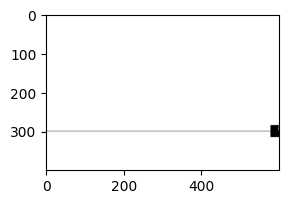

154.0

In [10]:
play(True)[-1]